In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This competition is about time series forcasting for store sales. The data comes from an Ecuador company as known as Corporación Favorita and it is a large grocery retailer. Also, the company operates in other countries in South America.

train data contains time series of the stores and the product families combination. The sales column gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).The onpromotion column gives the total number of items in a product family that were being promoted at a store at a given date.

Stores data gives some information about stores such as city, state, type, cluster.

Transaction data is highly correlated with train's sales column. You can understand the sales patterns of the stores.

Holidays and events data is a meta data. This data is quite valuable to understand past sales, trend and seasonality components. However, it needs to be arranged. You are going to find a comprehensive data manipulation for this data. That part will be one of the most important chapter in this notebook.

Daily Oil Price data is another data which will help us. Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. That's why, it will help us to understand which product families affected in positive or negative way by oil price.

# ***Importing the libraries***

In [ ]:
!pip install sklearn
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
import gc
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import csv
from google.colab import drive
from sklearn.metrics import r2_score
from sklearn.model_selection import PredefinedSplit
from xgboost import XGBRegressor

In [ ]:
gc.collect()

230

# *importing the data set*

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/data_set/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data_set/test.csv')
holidays_df = pd.read_csv('/content/drive/MyDrive/data_set/holidays_events.csv')
stores_df = pd.read_csv('/content/drive/MyDrive/data_set/stores.csv')
transactions_df = pd.read_csv('/content/drive/MyDrive/data_set/transactions.csv')
oil_df = pd.read_csv('/content/drive/MyDrive/data_set/oil.csv')

# **Store Sales Summary**

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.6, 1.6, 1.6, 1.6],
    mode="text", 
    text=["<span style='font-size:33px'><b>54</b></span>", 
          "<span style='font-size:33px'><b>33</b></span>",
          "<span style='font-size:33px'><b>16</b></span>",
          "<span style='font-size:33px'><b>56</b></span>"],
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.1, 1.1, 1.1, 1.1],
    mode="text", 
    text=["Stores", "Products", "States", "Months"],
    textposition="bottom center"
))
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=700, 
                  title='Store Sales Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.5,3.6], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=23, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=70,b=0,r=70), 
    )


# **combining the data**

In [ ]:
test_df.shape


(28512, 5)

In [ ]:
all_train_df = train_df.merge(oil_df, on = 'date', how='left')
all_train_df = all_train_df.merge(holidays_df, on = 'date', how='left')
all_train_df = all_train_df.merge(stores_df, on = 'store_nbr', how='left')
test_df = test_df.merge(stores_df, on = 'store_nbr', how='left')

all_train_df = all_train_df.merge(transactions_df, on = ['date', 'store_nbr'], how='left')
all_train_df = all_train_df.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})
all_train_df['date'] = pd.to_datetime(all_train_df['date'])
all_train_df['year'] = all_train_df['date'].dt.year
all_train_df['month'] = all_train_df['date'].dt.month
all_train_df['week'] = all_train_df['date'].dt.isocalendar().week
all_train_df['quarter'] = all_train_df['date'].dt.quarter
all_train_df['day_of_week'] = all_train_df['date'].dt.day_name()


# **Sales analysis**

In [ ]:

stores_analysis_df = all_train_df.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
cluster= all_train_df.groupby('cluster').agg({"sales" : "mean"}).reset_index() 

stores_analysis_df['color'] = '#496595'
stores_analysis_df['color'][2:] = '#c6ccd8'
cluster['color'] = '#c6ccd8'

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Pie(values=stores_analysis_df['sales'], labels=stores_analysis_df['store_type'], name='Store store_type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=cluster['cluster'], y=cluster['sales'], 
                     marker=dict(color= cluster['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=cluster.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white")
fig.show()


In [ ]:
a = all_train_df.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "sales", x="family", color = "family", title = " product family sales ?")

In [ ]:
week_day_df = all_train_df.groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
week_day_df.sales = round(week_day_df.sales, 2)

fig = px.bar(week_day_df, y='day_of_week', x='sales', title='average Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='sales',
             category_orders=dict(day_of_week=["Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday", "Friday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=5, r=0), height=500,
                  hovermode= "closest", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

# **Store Analysis**

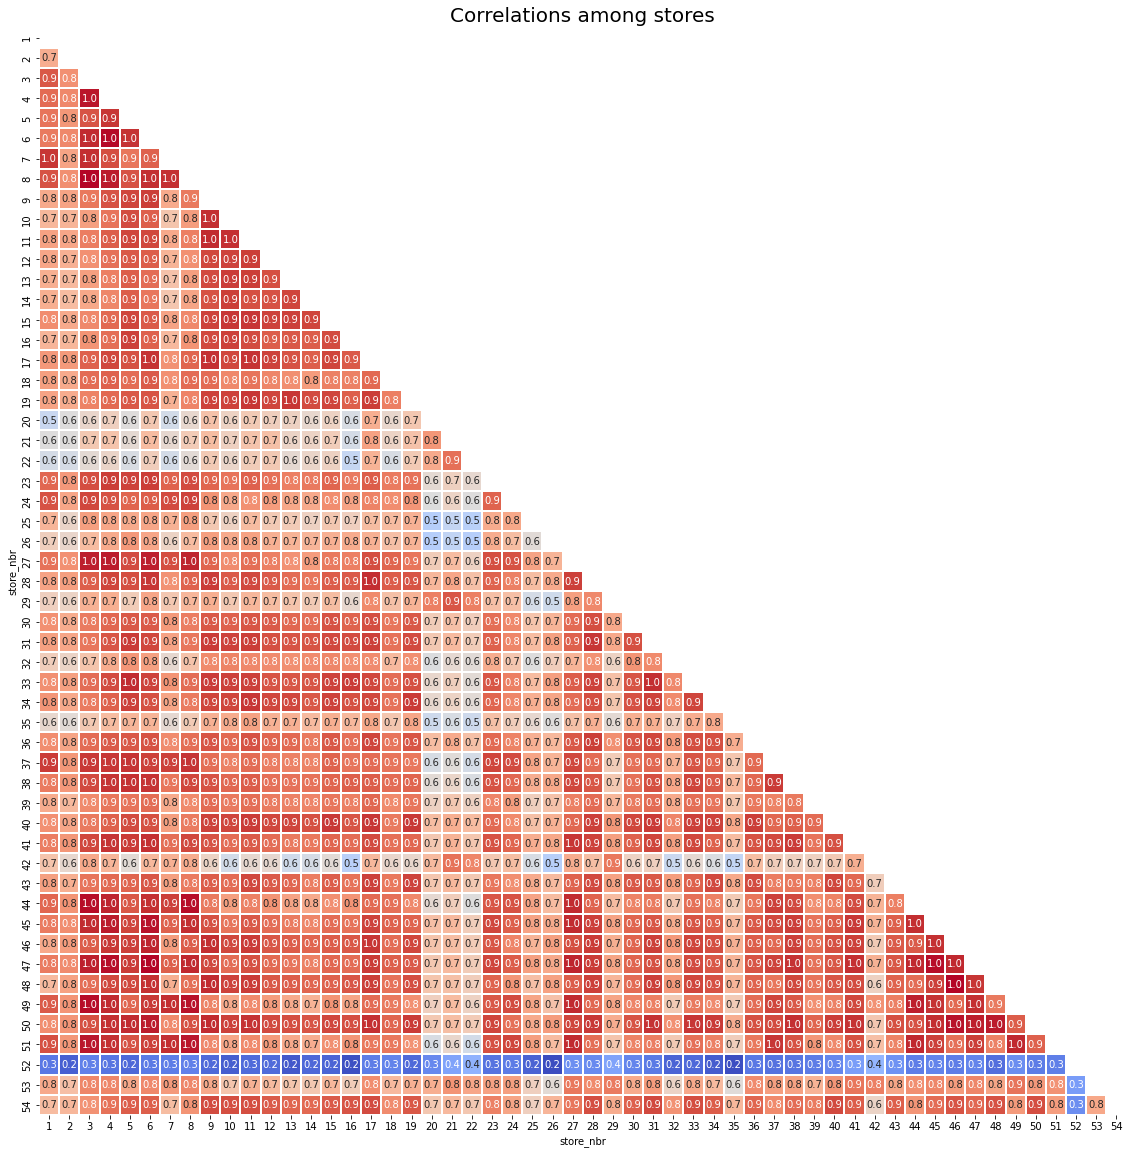

In [ ]:
a = train_df[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [ ]:
store_analysis_df = all_train_df.groupby(['store_type','holiday_type']).agg({"sales" : "mean"}).reset_index()
store_analysis_df['sales'] = round(store_analysis_df['sales'], 2)


fig = px.scatter(store_analysis_df, x='store_type', color='sales', y='holiday_type', size='sales',
                 color_discrete_sequence=px.colors.qualitative.D3,
                 title="Average Sales: Store Type Vs Holiday Type")

fig.update_yaxes(ticksuffix='  ')
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#168', family="Lato, sans-serif"),
                  font=dict(color='#868'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

# **Transactions Analysis**

In [ ]:
transactions_df.head(20)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [ ]:
print(" Correlation between Total Sales and Transactions: {:,.4f}".format(all_train_df.corr("spearman").sales.loc["transactions"]))
px.line(transactions_df.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

 Correlation between Total Sales and Transactions: 0.1703


# **Oil Price Analysis**

In [ ]:
# Resample
oil_df["date"] = pd.to_datetime(oil_df.date)
oil_df = oil_df.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil_df["dcoilwtico"] = np.where(oil_df["dcoilwtico"] == 0, np.nan, oil_df["dcoilwtico"])
oil_df["dcoilwtico_interpolated"] =oil_df.dcoilwtico.interpolate()
# Plot
p = oil_df.melt(id_vars=['date']+list(oil_df.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

Correlation with Daily Oil Prices
sales          -0.181736
transactions    0.038052
Name: dcoilwtico_interpolated, dtype: float64 



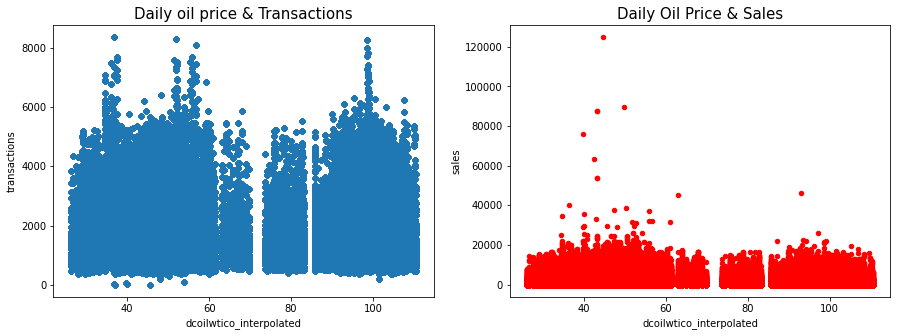

In [ ]:
all_train_df = pd.merge(all_train_df, oil_df, how = "left")
print("Correlation with Daily Oil Prices")
print(all_train_df.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")


fig, axes = plt.subplots(1, 2, figsize = (15,5))
all_train_df.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
all_train_df.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);

In [ ]:
test_df.shape


(28512, 9)

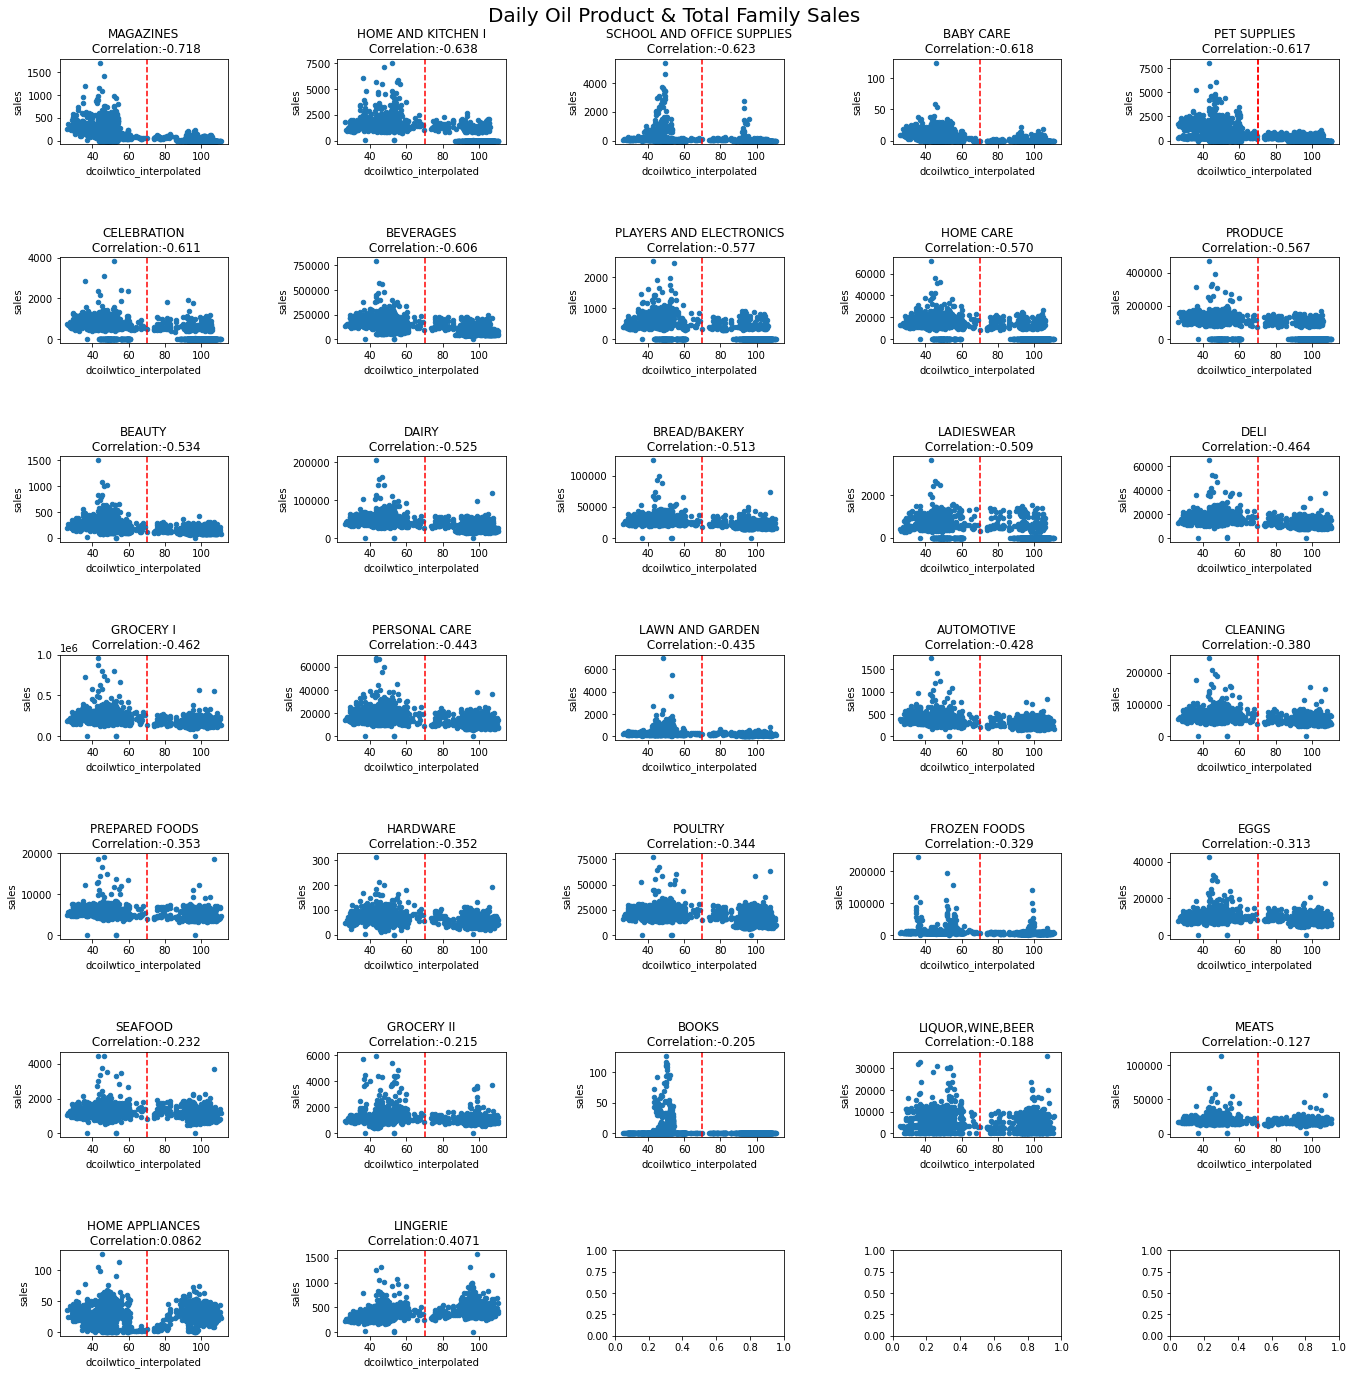

In [ ]:
a = pd.merge(all_train_df.groupby(["date", "family"]).sales.sum().reset_index(), oil_df.drop("dcoilwtico", axis = 1), how = "left")
c = a.groupby("family").corr("spearman").reset_index()
c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")

fig, axes = plt.subplots(7, 5, figsize = (20,20))
for i, fam in enumerate(c.family):
    if i < 6:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[0, i-1])
        axes[0, i-1].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    if i >= 6 and i<11:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1, i-6])
        axes[1, i-6].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[1, i-6].axvline(x=70, color='r', linestyle='--')
    if i >= 11 and i<16:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[2, i-11])
        axes[2, i-11].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[2, i-11].axvline(x=70, color='r', linestyle='--')
    if i >= 16 and i<21:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[3, i-16])
        axes[3, i-16].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[3, i-16].axvline(x=70, color='r', linestyle='--')
    if i >= 21 and i<26:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[4, i-21])
        axes[4, i-21].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[4, i-21].axvline(x=70, color='r', linestyle='--')
    if i >= 26 and i < 31:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[5, i-26])
        axes[5, i-26].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[5, i-26].axvline(x=70, color='r', linestyle='--')
    if i >= 31 :
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[6, i-31])
        axes[6, i-31].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[6, i-31].axvline(x=70, color='r', linestyle='--')
        
        
plt.tight_layout(pad=5)
plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize = 20);
plt.show()

# **On-Promotion and sales**

In [ ]:
print(" Correlation between Sales and Onpromotion: {:,.4f}".format(all_train_df.corr("spearman").sales.loc["onpromotion"]))

 Correlation between Sales and Onpromotion: 0.5394


# **cleaning the data**
Their is some product families which are never sold in certain stores so we can predict it will be zero on the next 15 days forcasting as well. we will collect these "certain" predection and merge it with the predection file.

In [ ]:
c = all_train_df.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


In [ ]:
"""
print(all_train_df.shape)
# Anti Join
outer_join = all_train_df.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
all_train_df = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
all_train_df.shape
"""

'\nprint(all_train_df.shape)\n# Anti Join\nouter_join = all_train_df.merge(c[c.sales == 0].drop("sales",axis = 1), how = \'outer\', indicator = True)\nall_train_df = outer_join[~(outer_join._merge == \'both\')].drop(\'_merge\', axis = 1)\ndel outer_join\nall_train_df.shape\n'

In [ ]:
"""
zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del c
zero_prediction
"""

'\nzero_prediction = []\nfor i in range(0,len(c)):\n    zero_prediction.append(\n        pd.DataFrame({\n            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),\n            "store_nbr":c.store_nbr.iloc[i],\n            "family":c.family.iloc[i],\n            "sales":0\n        })\n    )\nzero_prediction = pd.concat(zero_prediction)\ndel c\nzero_prediction\n'

In [ ]:
test_df.shape


(28512, 9)

# **Data Encoding**

In [ ]:
all_train_df['store_type']= all_train_df['store_type'].replace(['C' ,'E','B','D','A'],[1, 2, 3, 4, 5])
all_train_df['day_of_week']= all_train_df['day_of_week'].replace(['Saturday' ,'Sunday','Monday',
                                                                'Tuesday','Wednesday','Thursday'
                                                                ,'Friday'],[7, 6, 5, 4, 3 , 2, 1])
all_train_df.sample(10)


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,dcoilwtico_interpolated
731052,722142,2014-02-11,21,BEVERAGES,0.000,0,99.96,NaN,NaN,NaN,NaN,NaN,Santo Domingo,Santo Domingo de los Tsachilas,3,6,NaN,2014,2,7,1,4,99.960000
2529876,2487108,2016-10-30,42,PRODUCE,2593.176,0,NaN,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,4,2,1278.0,2016,10,43,4,6,47.460000
2695554,2649222,2017-01-30,41,HOME AND KITCHEN I,23.000,3,52.63,NaN,NaN,NaN,NaN,NaN,Machala,El Oro,4,4,902.0,2017,1,5,1,5,52.630000
308757,306975,2013-06-22,22,DELI,0.000,0,NaN,NaN,NaN,NaN,NaN,NaN,Puyo,Pastaza,1,7,NaN,2013,6,25,2,7,94.230000
1313918,1294316,2014-12-30,25,MAGAZINES,7.000,0,54.14,NaN,NaN,NaN,NaN,NaN,Salinas,Santa Elena,4,1,2710.0,2014,12,1,4,4,54.140000
927709,918799,2014-06-01,39,GROCERY II,38.000,0,NaN,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,3,6,1722.0,2014,6,22,2,6,103.180000
2804925,2758593,2017-04-02,10,MEATS,228.470,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,1,15,1039.0,2017,4,13,2,6,50.346667
2008107,1981377,2016-01-20,52,MEATS,0.000,0,26.68,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,5,11,NaN,2016,1,3,1,3,26.680000
2597683,2553133,2016-12-06,45,"LIQUOR,WINE,BEER",329.000,11,50.95,Holiday,Local,Quito,Fundacion de Quito,False,Quito,Pichincha,5,11,4516.0,2016,12,49,4,4,50.950000
206376,206376,2013-04-26,49,PLAYERS AND ELECTRONICS,0.000,0,92.63,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,5,11,1950.0,2013,4,17,2,1,92.630000


In [ ]:
test_df.shape


(28512, 9)

In [ ]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['day_of_week'] = test_df['date'].dt.day_name()
test_df = test_df.rename(columns = {"type" : "store_type"})
test_df['store_type']= test_df['store_type'].replace(['C' ,'E','B','D','A'],[1, 2, 3, 4, 5])
test_df['day_of_week']= test_df['day_of_week'].replace(['Saturday' ,'Sunday','Monday',
                                                               'Tuesday','Wednesday','Thursday'
                                                                ,'Friday'],[7, 6, 5, 4, 3 , 2, 1])
test_df.shape

(28512, 10)

In [ ]:
test_df.shape


(28512, 10)

In [ ]:
# fill nans
all_train_df['holiday_type'] = all_train_df['holiday_type'].fillna(0)
all_train_df.sample(10)
# Encoding
all_train_df = all_train_df.sample(100000)
for index, row in all_train_df.iterrows():
  if row['holiday_type'] != 0:
    if row['locale'] == 'National':
      all_train_df['holiday_type'][index] = 1 
    elif row['locale'] == 'Regional' and row['state'] == row['locale_name']:
      all_train_df['holiday_type'][index] = 1 
    elif row['locale'] == 'Local' and row['city'] == row['locale_name']:
       all_train_df['holiday_type'][index] = 1 
    else:
      all_train_df['holiday_type'][index] = 0


In [ ]:
# Holidays for the test
holidays_copy_df = holidays_df
test_df['date'] = test_df['date'].dt.strftime('%m-%d' )
holidays_copy_df['date'] = pd.to_datetime(holidays_copy_df['date'])
holidays_copy_df['date'] = holidays_copy_df['date'].dt.strftime('%m-%d' )



In [ ]:
test_df['holiday_type'] = 0
for index, row in test_df.iterrows():
  holidays_copy_df.where(holidays_copy_df['date'] == row['date'])
  if (row['date'] in holidays_copy_df['date'].values ) :
    test_df['holiday_type'][index] = 1 
  else:
    test_df['holiday_type'][index] = 0 


In [ ]:
test_df.sample(50)


,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,day_of_week,holiday_type
6762,3007650,08-19,48,PRODUCE,5,Quito,Pichincha,5,14,7,0
16302,3017190,08-25,17,AUTOMOTIVE,0,Quito,Pichincha,1,12,1,0
1991,3002879,08-17,15,FROZEN FOODS,1,Ibarra,Imbabura,1,15,2,0
23509,3024397,08-29,19,GROCERY II,0,Guaranda,Bolivar,1,15,4,0
2258,3003146,08-17,22,HARDWARE,0,Puyo,Pastaza,1,7,2,0
13403,3014291,08-23,35,BREAD/BAKERY,5,Playas,Guayas,1,3,3,0
9684,3010572,08-21,30,HOME AND KITCHEN I,1,Guayaquil,Guayas,1,3,5,0
25158,3026046,08-30,15,GROCERY I,70,Ibarra,Imbabura,1,15,3,0
8636,3009524,08-20,50,MAGAZINES,0,Ambato,Tungurahua,5,14,6,0
3824,3004712,08-18,16,PREPARED FOODS,0,Santo Domingo,Santo Domingo de los Tsachilas,1,3,1,0


In [ ]:

"""
test_df = test_df.rename(columns = {"type" : "holiday_type"})
test_df['holiday_type'] = test_df['holiday_type'].fillna(0)
#test_df['locale'] = test_df['locale'].fillna(0)
test_df.sample(10)
# Encoding
for index, row in test_df.iterrows():
  if row['holiday_type'] != 0:
    if row['locale'] == 'National':
      test_df['holiday_type'][index] = 1 
    elif row['locale'] == 'Regional' and row['state'] == row['locale_name']:
      #row['holiday_type'] = 1
      test_df['holiday_type'][index] = 1 
    elif row['locale'] == 'Local' and row['city'] == row['locale_name']:
      #row['holiday_type'] = 1
       test_df['holiday_type'][index] = 1 
    else:
      #row['holiday_type'] = 0
      test_df['holiday_type'][index] = 0
"""

'\ntest_df = test_df.rename(columns = {"type" : "holiday_type"})\ntest_df[\'holiday_type\'] = test_df[\'holiday_type\'].fillna(0)\n#test_df[\'locale\'] = test_df[\'locale\'].fillna(0)\ntest_df.sample(10)\n# Encoding\nfor index, row in test_df.iterrows():\n  if row[\'holiday_type\'] != 0:\n    if row[\'locale\'] == \'National\':\n      test_df[\'holiday_type\'][index] = 1 \n    elif row[\'locale\'] == \'Regional\' and row[\'state\'] == row[\'locale_name\']:\n      #row[\'holiday_type\'] = 1\n      test_df[\'holiday_type\'][index] = 1 \n    elif row[\'locale\'] == \'Local\' and row[\'city\'] == row[\'locale_name\']:\n      #row[\'holiday_type\'] = 1\n       test_df[\'holiday_type\'][index] = 1 \n    else:\n      #row[\'holiday_type\'] = 0\n      test_df[\'holiday_type\'][index] = 0\n'

In [ ]:
all_train_df['holiday_type'] = pd.to_numeric(all_train_df['holiday_type'])

In [ ]:
all_train_df_copy = all_train_df

# **products families cleaning**

In [ ]:
# collecting least soled products into one categori 'other'
a = all_train_df_copy.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
aa = a[15:]
all_train_df_copy["family"] = all_train_df_copy["family"].replace(aa['family'].to_numpy(), 'others')
#families =  a[:15].("others")
#families
# 1. Create the encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(all_train_df_copy['family'].to_frame())
# 3. Generate column names for each category
encoded_cols = list(encoder.get_feature_names())
len(encoded_cols)
all_train_df_copy[encoded_cols] = encoder.transform(all_train_df_copy['family'].to_frame())




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:

test_df['family']= test_df['family'].replace(aa['family'].to_numpy(), 'others')
test_df.sample(10)
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(test_df['family'].to_frame())
test_df[encoded_cols] = encoder.transform(test_df['family'].to_frame())

In [ ]:
test_df.shape


(28512, 27)

# **train-valdation sets split**

In [ ]:
all_train_df_copy = all_train_df_copy.sort_values("date")
start_date = '2013-01-01'
end_date = '2017-08-01'
mask1 = (all_train_df_copy['date'] > start_date) & (all_train_df_copy['date'] < end_date)
mask2 = (all_train_df_copy['date'] >= end_date)
training_set = all_train_df_copy.loc[mask1]
valdation_set = all_train_df_copy.loc[mask2]
valdation_set


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,dcoilwtico_interpolated,x0_BEVERAGES,x0_BREAD/BAKERY,x0_CLEANING,x0_DAIRY,x0_DELI,x0_EGGS,x0_FROZEN FOODS,x0_GROCERY I,x0_HOME CARE,"x0_LIQUOR,WINE,BEER",x0_MEATS,x0_PERSONAL CARE,x0_POULTRY,x0_PREPARED FOODS,x0_PRODUCE,x0_others
3028451,2974991,2017-08-01,32,DAIRY,180.000000,3,49.19,0,NaN,NaN,NaN,NaN,Guayaquil,Guayas,1,3,724.0,2017,8,31,3,4,49.19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3027864,2974404,2017-08-01,16,others,3.000000,0,49.19,0,NaN,NaN,NaN,NaN,Santo Domingo,Santo Domingo de los Tsachilas,1,3,770.0,2017,8,31,3,4,49.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3028205,2974745,2017-08-01,25,others,2.000000,0,49.19,0,NaN,NaN,NaN,NaN,Salinas,Santa Elena,4,1,839.0,2017,8,31,3,4,49.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3029054,2975594,2017-08-01,49,others,1.000000,0,49.19,0,NaN,NaN,NaN,NaN,Quito,Pichincha,5,11,3034.0,2017,8,31,3,4,49.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3029033,2975573,2017-08-01,48,PREPARED FOODS,74.145004,0,49.19,0,NaN,NaN,NaN,NaN,Quito,Pichincha,5,14,3003.0,2017,8,31,3,4,49.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053477,3000017,2017-08-15,34,others,2.000000,1,47.57,0,Local,Riobamba,Fundacion de Riobamba,False,Guayaquil,Guayas,3,6,2007.0,2017,8,33,3,4,47.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3053874,3000414,2017-08-15,45,others,17.000000,5,47.57,0,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,5,11,3685.0,2017,8,33,3,4,47.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3052826,2999366,2017-08-15,16,PREPARED FOODS,41.000000,0,47.57,0,Local,Riobamba,Fundacion de Riobamba,False,Santo Domingo,Santo Domingo de los Tsachilas,1,3,742.0,2017,8,33,3,4,47.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3054091,3000631,2017-08-15,51,CLEANING,1357.000000,9,47.57,0,Local,Riobamba,Fundacion de Riobamba,False,Guayaquil,Guayas,5,17,1573.0,2017,8,33,3,4,47.57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model_fetures = ['onpromotion','cluster','store_type' ,'store_nbr','day_of_week','dcoilwtico_interpolated','holiday_type'] + encoded_cols
print(model_fetures)

['onpromotion', 'cluster', 'store_type', 'store_nbr', 'day_of_week', 'dcoilwtico_interpolated', 'holiday_type', 'x0_BEVERAGES', 'x0_BREAD/BAKERY', 'x0_CLEANING', 'x0_DAIRY', 'x0_DELI', 'x0_EGGS', 'x0_FROZEN FOODS', 'x0_GROCERY I', 'x0_HOME CARE', 'x0_LIQUOR,WINE,BEER', 'x0_MEATS', 'x0_PERSONAL CARE', 'x0_POULTRY', 'x0_PREPARED FOODS', 'x0_PRODUCE', 'x0_others']


In [ ]:
start_date = '2016-01-01'
end_date = '2017-08-15'
mask = (oil_df['date'] > start_date) & (oil_df['date'] < end_date)
oil_average_value = oil_df.loc[mask].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [ ]:
oil_average_value = oil_average_value.dcoilwtico_interpolated

In [ ]:
test_df['dcoilwtico_interpolated']  = oil_average_value
test_df['dcoilwtico_interpolated'] = test_df['dcoilwtico_interpolated'].fillna(oil_average_value)

In [ ]:
x_train = training_set[model_fetures] 
y_train = training_set['sales']
x_valdation = valdation_set[model_fetures]
y_valdation = valdation_set['sales']
x_test = test_df[model_fetures]
x_train.sample(5)


,onpromotion,cluster,store_type,store_nbr,day_of_week,dcoilwtico_interpolated,holiday_type,x0_BEVERAGES,x0_BREAD/BAKERY,x0_CLEANING,x0_DAIRY,x0_DELI,x0_EGGS,x0_FROZEN FOODS,x0_GROCERY I,x0_HOME CARE,"x0_LIQUOR,WINE,BEER",x0_MEATS,x0_PERSONAL CARE,x0_POULTRY,x0_PREPARED FOODS,x0_PRODUCE,x0_others
353820,0,10,2,36,6,106.083333,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
489393,0,3,1,40,7,102.693333,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2160129,0,15,1,19,1,40.400000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
552312,0,13,4,6,7,94.566667,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2952960,0,7,1,14,1,42.860000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
training_set.dtypes

id                                  int64
date                       datetime64[ns]
store_nbr                           int64
family                             object
sales                             float64
onpromotion                         int64
dcoilwtico                        float64
holiday_type                        int64
locale                             object
locale_name                        object
description                        object
transferred                        object
city                               object
state                              object
store_type                          int64
cluster                             int64
transactions                      float64
year                                int64
month                               int64
week                               UInt32
quarter                             int64
day_of_week                         int64
dcoilwtico_interpolated           float64
x0_BEVERAGES                      

# **Model (1) (Ridge Regression)**

In [ ]:
#Ridge Model
model1 =Ridge()
Ridge_reg= GridSearchCV(model1, param_grid={'alpha':np.arange(1,100,5)}, scoring='neg_mean_squared_error',cv=5)
Ridge_reg.fit(x_train,y_train)
model1 = Ridge_reg.best_estimator_
print(Ridge_reg.best_score_)
Ridge_reg.best_params_
y_predicted = model1.predict(x_train)
mse = mean_squared_error(y_predicted, y_train)
r2 = r2_score(y_predicted, y_train)
print(mse)
print(r2)



-598734.0007771056
575308.8435880743
0.17352696972549697


In [ ]:

gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [200],
              'max_features': [12],
              'max_depth': [6],
              'learning_rate': [1],
              'subsample': [0.5],
             'random_state' : [7],
              'criterion': ['r2']}
                       
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=8)
gb_model.fit(x_train, y_train)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterio

GridSearchCV(cv=8, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'criterion': ['mse'], 'learning_rate': [1],
                         'max_depth': [2], 'max_features': [12],
                         'n_estimators': [2000], 'random_state': [7],
                         'subsample': [0.5]})

In [ ]:

y_predicted = gb_model.predict(x_train)
mse = mean_squared_error(y_predicted, y_train)
r2 = r2_score( y_train, y_predicted)
print(mse)
print(r2)

239598.54482677561
0.8140776793127378


In [ ]:
# valdation
y_predicted = gb_model.predict(x_valdation)
mse = mean_squared_error(y_predicted, y_valdation)
r2 = r2_score(y_valdation,y_predicted)
print(mse)
print(r2)

319890.27711941366
0.7747273177077579


In [ ]:
all_train_df_copy[model_fetures].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1687 to 3053280
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   onpromotion          100000 non-null  int64  
 1   store_type           100000 non-null  int64  
 2   cluster              100000 non-null  int64  
 3   day_of_week          100000 non-null  int64  
 4   x0_BEVERAGES         100000 non-null  float64
 5   x0_BREAD/BAKERY      100000 non-null  float64
 6   x0_CLEANING          100000 non-null  float64
 7   x0_DAIRY             100000 non-null  float64
 8   x0_DELI              100000 non-null  float64
 9   x0_EGGS              100000 non-null  float64
 10  x0_FROZEN FOODS      100000 non-null  float64
 11  x0_GROCERY I         100000 non-null  float64
 12  x0_HOME CARE         100000 non-null  float64
 13  x0_LIQUOR,WINE,BEER  100000 non-null  float64
 14  x0_MEATS             100000 non-null  float64
 15  x0_PERSONAL C

In [ ]:

drive.mount('/content/drive')
f = open('gb_CSV_file.csv', 'w')
gb_y_submit = gb_model.predict(x_test)
df_sub = pd.read_csv('/content/drive/MyDrive/data_set/sample_submission.csv', index_col='id')
df_sub.sales = gb_y_submit
df_sub.to_csv('submission.csv', index=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Random forest**

In [ ]:

param_grid = { 'bootstrap': [True], 'max_depth': [10,11,12,13,14,15,16,17], 'max_features': ['auto', 'log2'], 'n_estimators': [35]}
model = RandomForestRegressor(random_state = 12)
split_index = [-1 if x in x_train.index else 0 for x in all_train_df_copy[model_fetures].index]
pds = PredefinedSplit(test_fold = split_index)
g_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = pds , return_train_score=True)
g_search.fit(all_train_df_copy[model_fetures] ,all_train_df_copy['sales'])

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 0, 0])),
             estimator=RandomForestRegressor(random_state=12),
             param_grid={'bootstrap': [True],
                         'max_depth': [10, 11, 12, 13, 14, 15, 16, 17],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [35]},
             return_train_score=True)

In [ ]:
y_predicted = g_search.predict(x_train)
mse = mean_squared_error(y_predicted, y_train)
r2 = r2_score( y_train, y_predicted)
print(mse)
print(r2)

179783.70199674525
0.8615003377098963


In [ ]:
# valdation
y_predicted = g_search.predict(x_valdation)
mse = mean_squared_error(y_predicted, y_valdation)
r2 = r2_score(y_valdation,y_predicted)
print(mse)
print(r2)

88484.52888597647
0.9451194865864939


In [ ]:
g_search.best_params_

{'bootstrap': True,
 'max_depth': 11,
 'max_features': 'log2',
 'n_estimators': 35}

In [ ]:
#drive.mount('/content/drive')
f = open('gb_CSV_file.csv', 'w')
rf_y_submit = g_search.predict(x_test)
df_sub = pd.read_csv('/content/drive/MyDrive/data_set/sample_submission.csv', index_col='id')
df_sub.sales = rf_y_submit
df_sub.to_csv('rfsubmission.csv', index=True)


# **XGBoost**

In [ ]:
xgb_params = {
    'tree_method': 'gpu_hist', 
    'gpu_id': 0,
    'predictor': 'gpu_predictor', 
    'verbosity': 2,
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'random_state': 2021,
    'learning_rate': 0.009948916127719946,
    'subsample': 0.9963593946651406,
    'colsample_bytree': 0.8056779523100791,
    'reg_alpha': 10.0,
    'reg_lambda': 0.1801543144548864,
    'min_child_weight': 47,
}

In [ ]:
reg = XGBRegressor(params=xgb_params)
reg.fit(x_train, 
        y_train,
        eval_set=[(x_train, y_train), (x_valdation, y_valdation)]
        )

[20:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1080.21	validation_1-rmse:1211.79
[1]	validation_0-rmse:1021.85	validation_1-rmse:1149.32
[2]	validation_0-rmse:971.579	validation_1-rmse:1095
[3]	validation_0-rmse:927.803	validation_1-rmse:1050.48
[4]	validation_0-rmse:890.081	validation_1-rmse:1001.69
[5]	validation_0-rmse:857.553	validation_1-rmse:969.208
[6]	validation_0-rmse:829.25	validation_1-rmse:931.021
[7]	validation_0-rmse:805.321	validation_1-rmse:892.491
[8]	validation_0-rmse:783.214	validation_1-rmse:868.92
[9]	validation_0-rmse:765.058	validation_1-rmse:845.803
[10]	validation_0-rmse:748.602	validation_1-rmse:821.635
[11]	validation_0-rmse:734.725	validation_1-rmse:802.664
[12]	validation_0-rmse:722.387	validation_1-rmse:785.961
[13]	validation_0-rmse:711.526	validation_1-rmse:764.886
[14]	validation_0-rmse:699.886	validation_1-rmse:749.298
[15]	validation_0-rmse:689.966	va

XGBRegressor(params={'colsample_bytree': 0.8056779523100791,
                     'eval_metric': 'rmse', 'gpu_id': 0,
                     'learning_rate': 0.009948916127719946,
                     'min_child_weight': 47, 'objective': 'reg:squarederror',
                     'predictor': 'gpu_predictor', 'random_state': 2021,
                     'reg_alpha': 10.0, 'reg_lambda': 0.1801543144548864,
                     'subsample': 0.9963593946651406, 'tree_method': 'gpu_hist',
                     'verbosity': 2})

In [ ]:
y_predicted = reg.predict(x_valdation)
mse = mean_squared_error(y_predicted, y_valdation)
r2 = r2_score(y_valdation,y_predicted)
print(mse)
print(r2)

261370.8119195442
0.8134570098533715


In [ ]:
XG_y_submit = reg.predict(x_test)
df_sub = pd.read_csv('/content/drive/MyDrive/data_set/sample_submission.csv', index_col='id')
df_sub.sales = XG_y_submit
df_sub.to_csv('XGsubmission.csv', index=True)
